In [1]:
import pickle
import networkx as nx
import json
import pandas as pd
from pyvis.network import Network

f= open('data/grafo_autores.json') 
data_autores = json.load(f)
f.close()

f= open('data/lista_papers.json')
data_papers = json.load(f)
f.close()

f= open('data/grafo_instituciones.json') 
data_inst = json.load(f)
f.close()

f= open('data/lista_papers_instituciones.json') 
data_paper_inst = json.load(f)
f.close()

with open("data/cluster_authorrank_2000.pkl", "rb") as f:
        data_cluster = pickle.load(f)

with open("data/cluster_filiacion_authorrank_500.pkl", "rb") as f:
        data_cluster_filiacion = pickle.load(f)

salida_articulos = pd.read_excel("data/output_articles.xlsx")
salidas_topicos = pd.read_excel("data/salidas_topicos_CB.xlsx")
salida_autores = pd.read_excel("data/salida_autores.xlsx")


#El nuevo data_papers viene con los values de nodos en entero, hay que convertirlos a str para que el codigo funcione sin modificaciones.
data_papers_str = {}
for key, value in data_papers.items():
    data_papers_str[key] = [str(node) for node in value]

data_papers = data_papers_str

In [2]:
# La enumeracion del cluster va en orden descendente de acuerdo al 
# orden de los grandes productores

Enumerar_cluster = {}

for i, ele in enumerate(data_cluster, start = 1):
    Enumerar_cluster[i] = ele.split('_')

Enumerar_nodo = {}
for key, lista_nodos in Enumerar_cluster.items():
    for nodo in lista_nodos:
        Enumerar_nodo[nodo] = key

['38', '3970', '2279', '3974', '5059', '1046', '7144', '8559', '5041', '5044', '4765', '7662']
['133', '90', '4197']
['1231', '3239', '584']
['1638', '2750', '7213', '3124', '5662']
['9987', '7951', '9675', '472', '8977', '3638', '923', '7323', '5736']
['4216', '2734', '729', '617', '6126', '2598']
['1508', '2229', '4013', '1380', '4014', '2752', '4017', '4015', '4667', '3022', '2519', '811', '4668', '2590', '7160', '4016']
['10062', '10063', '7996', '7997', '7998', '7995', '2700', '1128', '1281', '1044', '8881', '7238', '8880', '3641', '8879', '3262', '8878', '2898', '8877', '2812', '8875', '2401', '3364', '489', '3606', '480', '8876', '3437', '7241', '7239', '3720', '3349', '8489', '7232', '7237', '7234', '7235', '7233', '6545', '6525', '7236', '7245', '8900', '8596', '7231', '7243', '8899', '8897', '8898', '8895', '8896', '8894', '8892', '8891', '8893', '8888', '8890', '8887', '8889', '8886', '7246', '8884', '7244', '8883', '7242', '8882', '7240', '10064', '10065']
['3963', '3965', 

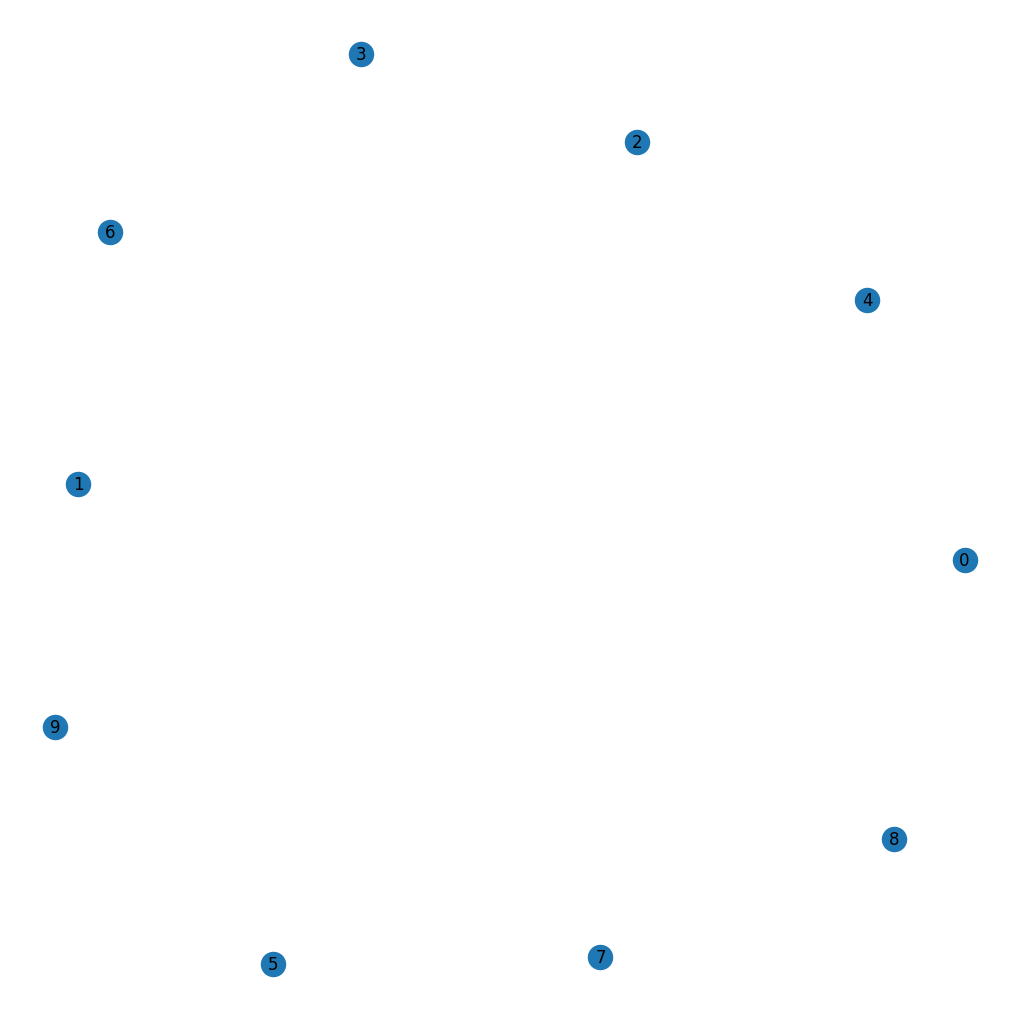

In [17]:
# Quiero tomar las primeras 20 comunidades, y conectarlas por coautiría
import matplotlib.pyplot as plt

n_comn = 20

G = nx.Graph()
for i in range(1, n_comn + 1):
    print(Enumerar_cluster[i])
    for node in Enumerar_cluster[i]:
        
        G.add_nodes_from(node)

# Dibujar el grafo
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True)
plt.show()